In [6]:
# import dataset and processing libraries
from random import randint
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# result visualization libraries
import matplotlib.pyplot as plt
import matplotlib

# Loading and Preparing Data

In [7]:
# load dataset (test12345)
mnist = fetch_openml('mnist_784')

In [8]:
# load dataset
X, y = mnist["data"], mnist["target"]

# Normalize all image data from [0, 255] to [0, 1]
X = X / 255

# One hot encoding to create labels for the 10 digits (0,1,2,3,4,5,6,7,8,9)

# creates a variables holding shape of the new labels
digits = 10 # new cols
examples = y.shape[0] # new rows

# shape from (70000,) to (1, 70000)
y = y.reshape(1, examples)

# convert from single column target to one hot encoded array (1, 70000, 10)
y_new = np.eye(digits)[y.astype('int32')]
# shaped to (10, 70000)
y_new = y_new.T.reshape(digits, examples)

In [5]:
# split, shape and shuffle data
# set size for training set (60000)
m = 60000

# splits inputs into X train and test, using sizes above
X_train, X_test = X[:m].T, X[m:].T
# splits output into y train and test
y_train, y_test = y_new[:,:m], y_new[:,m:]

# shuffle training data
np.random.seed(42) # reproducibility
shuffle_index = np.random.permutation(m)
X_train, y_train = X_train[:,shuffle_index], y_train[:,shuffle_index]

Data Visualization

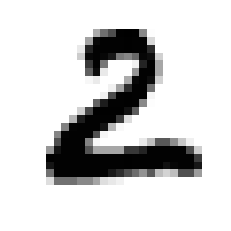

Label: 2


In [46]:
# sanity check to see if pictures correspond with appropriate label from one-hot encoding
# chose random image in train set
i = randint(0,m-1)

# plot train sample after reshaping back into square image
plt.imshow(X_train[:,i].reshape(28,28), cmap=matplotlib.cm.binary)
plt.axis("off")
plt.show()
# Print corresponding label
print(f"Label: {np.argmax(y_train[:,i],axis=0)}")

# Model 1

Required functions

In [7]:
'''
takes input image and applies a forward pass through a MLP with 1 hidden layer
input: 
X (all training data), 
W1,b1,W2,b2 (weights and biases of network)
output: 
Y_pred,
tmp (calculated outputs and activations)'''
def forward_pass(X, weights):
    W1, b1, W2, b2 = weights
    # calculating output of first layer, matrix multiplication of weights times input + bias
    Z1 = np.matmul(W1,X) + b1
    # sigmoid activation function applied to output of first/hidden layer
    A1 = sigmoid(Z1)
    # calculating output of activation values from hidden layer * weights + bias 
    Z2 = np.matmul(W2,A1) + b2
    # softmax activation function applied to output of output layer
    A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)
    # output of network
    Y_pred = A2
    # data to pass to back_propagate
    tmp = (Z1,A1,Z2,A2)
    
    return Y_pred, tmp


'''
takes Y true and pred, network parameters and the values of forward_pass
to apply back propagation training to the weights and biases
input:
Y, 
Y_pred, 
weights (W1, b1, W2, b2), 
momentum, 
learning_rate, 
tmp (Z1,A1,Z2,A2),
X
output:
weights (W1, b1, W2, b2)'''
def back_propagate(Y, Y_pred, weights, momentum, learning_rate, tmp, X):
    ## calculating back propagation deltas
    # unpack weights
    W1, b1, W2, b2 = weights
    # unpack value calculated during forward pass
    Z1,A1,Z2,A2 = tmp
    # num_samples
    m = X.shape[1]
    # error at output
    A2 = Y_pred # pred == output of layer 2
    dZ2 = A2-Y
    # backpropagate error to hidden layer
    dW2 = (1./m) * np.matmul(dZ2, A1.T)
    db2 = (1./m) * np.sum(dZ2, axis=1, keepdims=True)
    # multiply ouput error by hidden layer weights to calculate activation of hidden layer
    dA1 = np.matmul(W2.T, dZ2)
    #error at hidden layer (sigmoid y' = y(y-1))
    dZ1 = dA1 * (sigmoid(Z1) * (1 - sigmoid(Z1)))
    # backpropagate error to input layer
    dW1 = (1./m) * np.matmul(dZ1, X.T)
    db1 = (1./m) * np.sum(dZ1, axis=1, keepdims=True)

    # apply momemtum
    dW1 = (momentum * dW1 + (1. - momentum) * dW1)
    db1 = (momentum * db1 + (1. - momentum) * db1)
    dW2 = (momentum * dW2 + (1. - momentum) * dW2)
    db2 = (momentum * db2 + (1. - momentum) * db2)
    
    # update and return weights
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    weights = (W1,b1,W2,b2)
    return weights
    
    
'''
sigmoid function applies the activation function to the output of neuron
input: z (output at neuron)
output: activation (output of neuron)'''
def sigmoid(z):
    activation = 1 / (1 + np.exp(-z))
    return activation


'''
compute loss/error of predictions against ground truth
input: Y (ground truth table), Y_hat (prediction table)
output: L (loss/error)'''
def compute_multiclass_loss(Y, Y_hat):
    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1/m) * L_sum
    return L

# Build and train networks

In [16]:

# set seed so weights initialize in reproducable manner
np.random.seed(42) 

# network parameters
n_x = X_train.shape[0] # num input nodes
n_h = 64               # num hidden layer nodes
learning_rate = 1      # learning rate
epochs = 200   # epochs
momentum = 0.5         # momentum

# setting random biases and weights for input layer
W1 = np.random.randn(n_h, n_x)
b1 = np.zeros((n_h, 1))
# setting random biases and weights for hidden layer
W2 = np.random.randn(digits, n_h)
b2 = np.zeros((digits, 1))

# loop k epochs to train
for i in range(epochs):
    
    # pass train data into network and get output
    # also returns inbetween calculated values for back propagation
    weights = (W1, b1, W2, b2) # pack weights for easier passing
    y_pred, tmp = forward_pass(X_train, weights)

    # compute loss using cross entropy (ground truth, predictions)
    loss = compute_multiclass_loss(y_train, y_pred)

    # compute updated weights using back propagation
    W1,b1,W2,b2 = back_propagate(y_train, y_pred, weights, momentum, learning_rate, tmp, X_train)

    # report cost every 100 epochs
    if (i % 100 == 0):
        print("Epoch", i, "loss: ", loss)

print("Final loss:", loss)
print()

predictions = np.argmax(y_pred, axis=0)
labels = np.argmax(y_train, axis=0)

print("Train data stats:")
print(confusion_matrix(predictions, labels))
print(classification_report(predictions, labels))

Epoch 0 loss:  9.09999229262521
Epoch 100 loss:  0.7266731887531831
Final loss: 0.5518701951222055

Train data stats:
[[5343    1  124   69   28  197  100   56   69   42]
 [   1 6400   92   41   15   43   37  115  166   15]
 [  71   70 4777  201   64   82  175  147  164   62]
 [  56   18  182 4919   18  416   13   49  355  112]
 [  12   11  153   19 4855  108  107  142  109  399]
 [ 191   30   48  385   44 3933  133   44  318   99]
 [ 136   11  193   31  165  153 5257   16   90   32]
 [  41   26  143   69   67   39   17 5318   59  309]
 [  57  156  212  320  121  319   60   65 4284  144]
 [  15   19   34   77  465  131   19  313  237 4735]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      6029
           1       0.95      0.92      0.94      6925
           2       0.80      0.82      0.81      5813
           3       0.80      0.80      0.80      6138
           4       0.83      0.82      0.83      5915
           5       0.73   

Results for test data

In [15]:
## 100 epochs
# pass test data into trained network and get output
weights = W1, b1, W2, b2
y_pred,_ = forward_pass(X_test, weights)

cost = compute_multiclass_loss(y_test, y_pred)
print("Final loss:", cost)

predictions = np.argmax(y_pred, axis=0)
labels = np.argmax(y_test, axis=0)

print("Test data stats:")
print(confusion_matrix(predictions, labels))
print(classification_report(predictions, labels))

Final loss: 0.6927345992527022
Test data stats:
[[ 867    0   31   13    5   43   32   10   21    9]
 [   0 1052   31    2    3    4    3   27   11    5]
 [  21   19  763   30   13   24   52   31   25   11]
 [   7    4   53  806    2   95    2   19   93   14]
 [   5    1   26    4  762   23   33   25   29   82]
 [  40    3   10   78    7  591   27   10   57   27]
 [  25    2   43    2   35   27  786    3   28    6]
 [   5    5   28   12   17    7    6  815   16   58]
 [   9   48   41   52   27   59   12   28  627   13]
 [   1    1    6   11  111   19    5   60   67  784]]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1031
           1       0.93      0.92      0.93      1138
           2       0.74      0.77      0.76       989
           3       0.80      0.74      0.77      1095
           4       0.78      0.77      0.77       990
           5       0.66      0.70      0.68       850
           6       0.82      0.82      0.8

In [18]:
## 200 epochs
# pass test data into trained network and get output
weights = W1, b1, W2, b2
y_pred,_ = forward_pass(X_test, weights)

cost = compute_multiclass_loss(y_test, y_pred)
print("Final loss:", cost)

predictions = np.argmax(y_pred, axis=0)
labels = np.argmax(y_test, axis=0)

print("Test data stats:")
print(confusion_matrix(predictions, labels))
print(classification_report(predictions, labels))

Final loss: 0.5264352336787862
Test data stats:
[[ 901    0   26    8    4   38   27    7   17    6]
 [   0 1073   16    3    2    1    3   27    7    4]
 [  14    8  841   29    9   14   24   34   21    7]
 [   3    4   33  851    1   69    1   12   71    9]
 [   2    2   22    2  826   21   26   18   19   70]
 [  32    2    4   61    7  662   25    4   54   22]
 [  18    3   31    4   21   25  841    2   23    5]
 [   3    3   23    9   10    5    2  853   18   42]
 [   7   39   30   35   17   46    6   21  700   16]
 [   0    1    6    8   85   11    3   50   44  828]]
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1034
           1       0.95      0.94      0.94      1136
           2       0.81      0.84      0.83      1001
           3       0.84      0.81      0.82      1054
           4       0.84      0.82      0.83      1008
           5       0.74      0.76      0.75       873
           6       0.88      0.86      0.8

# Mini batch, model 1

In [9]:
##Build and train network

# set seed so weights initialize in reproducable manner
np.random.seed(42) 

# network parameters
n_x = X_train.shape[0] # num input nodes
n_h = 64               # num hidden layer nodes
learning_rate = 1      # learning rate
epochs = 20            # epochs
momentum = 0.5         # momentum
batch_size = 200      #

# setting random biases and weights for input layer
W1 = np.random.randn(n_h, n_x)
b1 = np.zeros((n_h, 1))
# setting random biases and weights for hidden layer
W2 = np.random.randn(digits, n_h)
b2 = np.zeros((digits, 1))
y_pred = np.zeros_like(y_train)
# loop k epochs to train
for i in range(epochs):
    
    #batch training
    for k in range(0, X_train.shape[1], batch_size):
      X_mini = X_train[:,k:k+batch_size]
      y_mini = y_train[:,k:k+batch_size]
      # pass train data into network and get output
      # also returns inbetween calculated values for back propagation
      weights = (W1, b1, W2, b2) # pack weights for easier passing
      y_pred_mini, tmp = forward_pass(X_mini, weights)

      # compute loss using cross entropy (ground truth, predictions)
      loss = compute_multiclass_loss(y_mini, y_pred_mini)

      # compute updated weights using back propagation
      W1,b1,W2,b2 = back_propagate(y_mini, y_pred_mini, weights, momentum, learning_rate, tmp, X_mini)
      
      y_pred[:,k:k+batch_size] = y_pred_mini
      #visualize progress
      batch_num = int((k+batch_size)/batch_size)
      if (batch_num % 20 == 0):
        print(f'Batch progress: {batch_num}/{int(m/batch_size)}')

    # report cost every 10 epochs
    if (i % 10 == 0):
        print("Epoch", i, "loss: ", loss)

print("Final loss:", loss)
print()

predictions = np.argmax(y_pred, axis=0)
labels = np.argmax(y_train, axis=0)

print("Train data stats:")
print(confusion_matrix(predictions, labels))
print(classification_report(predictions, labels))

Batch progress: 20/300
Batch progress: 40/300
Batch progress: 60/300
Batch progress: 80/300
Batch progress: 100/300
Batch progress: 120/300
Batch progress: 140/300
Batch progress: 160/300
Batch progress: 180/300
Batch progress: 200/300
Batch progress: 220/300
Batch progress: 240/300
Batch progress: 260/300
Batch progress: 280/300
Batch progress: 300/300
Epoch 0 loss:  0.5061789116342031
Batch progress: 20/300
Batch progress: 40/300
Batch progress: 60/300
Batch progress: 80/300
Batch progress: 100/300
Batch progress: 120/300
Batch progress: 140/300
Batch progress: 160/300
Batch progress: 180/300
Batch progress: 200/300
Batch progress: 220/300
Batch progress: 240/300
Batch progress: 260/300
Batch progress: 280/300
Batch progress: 300/300
Batch progress: 20/300
Batch progress: 40/300
Batch progress: 60/300
Batch progress: 80/300
Batch progress: 100/300
Batch progress: 120/300
Batch progress: 140/300
Batch progress: 160/300
Batch progress: 180/300
Batch progress: 200/300
Batch progress: 22

In [10]:
# pass test data into trained network and get output
weights = W1, b1, W2, b2
y_pred,_ = forward_pass(X_test, weights)

cost = compute_multiclass_loss(y_test, y_pred)
print("Final loss:", cost)

predictions = np.argmax(y_pred, axis=0)
labels = np.argmax(y_test, axis=0)

print("Test data stats:")
print(confusion_matrix(predictions, labels))
print(classification_report(predictions, labels))

Final loss: 0.20033133006317197
Test data stats:
[[ 963    0    9    1    1    8   10    1   10    6]
 [   0 1115    2    4    2    1    3   11    3    6]
 [   1    3  965   13    8    2    4   19    7    2]
 [   2    2   16  949    1   34    1   14   18    8]
 [   0    0    7    1  914    4    7    5    9   26]
 [   4    1    1   21    0  792    8    1   17    8]
 [   8    5   11    1   16   18  923    0   14    1]
 [   2    2    6    7    3    4    0  947    4    9]
 [   0    7   13   10    4   21    2    3  880    5]
 [   0    0    2    3   33    8    0   27   12  938]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1009
           1       0.98      0.97      0.98      1147
           2       0.94      0.94      0.94      1024
           3       0.94      0.91      0.92      1045
           4       0.93      0.94      0.94       973
           5       0.89      0.93      0.91       853
           6       0.96      0.93      0.

# Model 2 

Implement scikit MLP

In [33]:
# Load and normalize data again
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255

# training samples
m = 60000

# train/test split ()
X_train, X_test = X[:m,:], X[m:,:]
y_train, y_test = y[:m], y[m:]

# shuffle training data
np.random.seed(42) # reproducibility
shuffle_index = np.random.permutation(m)
X_train, y_train = X_train[shuffle_index,:], y_train[shuffle_index]

In [38]:
##Build and train scikit MLP network

# network parameters
n_x = X_train.shape[1] # num input nodes
n_h = 64               # num hidden layer nodes
learning_rate = 1      # learning rate
epochs = 50            # epochs
momentum = 0.5         # momentum

# initialize
classifier_neural_MLP = MLPClassifier(hidden_layer_sizes=n_h, max_iter=epochs, momentum=momentum)
# train
classifier_neural_MLP.fit(X_train, y_train.ravel())



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=64, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=50,
              momentum=0.5, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [43]:
y_pred_MLP.ravel()

array(['7', '2', '1', ..., '4', '5', '6'], dtype='<U1')

In [42]:
# predict
y_pred_MLP = classifier_neural_MLP.predict(X_train)

print("Train data stats:")
print(confusion_matrix(y_pred_MLP, y_train))
print(classification_report(y_pred_MLP, y_train))

# predict test
y_pred_MLP = classifier_neural_MLP.predict(X_test)

print("Test data stats:")
print(confusion_matrix(y_pred_MLP, y_test))
print(classification_report(y_pred_MLP, y_test))

Train data stats:
[[5923    0    0    0    0    0    0    0    0    0]
 [   0 6742    0    0    0    0    0    0    0    0]
 [   0    0 5958    0    0    0    0    0    0    0]
 [   0    0    0 6131    0    0    0    0    0    0]
 [   0    0    0    0 5842    0    0    0    0    0]
 [   0    0    0    0    0 5421    0    0    0    0]
 [   0    0    0    0    0    0 5918    0    0    0]
 [   0    0    0    0    0    0    0 6265    0    0]
 [   0    0    0    0    0    0    0    0 5851    0]
 [   0    0    0    0    0    0    0    0    0 5949]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5923
           1       1.00      1.00      1.00      6742
           2       1.00      1.00      1.00      5958
           3       1.00      1.00      1.00      6131
           4       1.00      1.00      1.00      5842
           5       1.00      1.00      1.00      5421
           6       1.00      1.00      1.00      5918
           7      

MLP random search

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_predict

param_grid = {
    'hidden_layer_sizes':[32,64,96,128],#[32,50,80,100,120,150],
    'activation':['identity','logistic','tanh','relu'],
    'learning_rate':['constant', 'invscaling', 'adaptive'],
    'solver':['ibfgs','sgd','adam'],
    'batch_size':[100,200,300,500],
    'max_iter':[50,100,200,250]
}

grid_search = GridSearchCV(
    MLPClassifier(), param_grid=param_grid, cv=7, refit = True, verbose=3, n_jobs=-1,
    scoring='accuracy')


grid_search.fit(X,y)

print('best score {}'.format(grid_search.best_score_)) 
print('best score {}'.format(grid_search.best_params_))

In [44]:
##Build and train scikit MLP network with best parameters set
best_params = {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': 128, 'batch_size': 250, 'activation': 'logistic'}
# initialize
classifier_neural_MLP = MLPClassifier(**best_params)
# train
classifier_neural_MLP.fit(X_train, y_train)
# predict
y_pred_MLP = classifier_neural_MLP.predict(X_test)

In [45]:
print("Test data stats:")
print(confusion_matrix(y_pred_MLP, y_test))
print(classification_report(y_pred_MLP, y_test))

Test data stats:
[[ 972    1    3    0    1    3    5    1    5    1]
 [   0 1122    0    0    0    1    2    2    0    2]
 [   1    4 1009    8    0    0    1   10    2    0]
 [   1    0    5  984    1    8    1    2    4    4]
 [   2    0    1    0  961    3    3    1    6   11]
 [   0    1    0    5    0  867    5    1    4    2]
 [   2    2    4    0    6    5  940    0    5    1]
 [   1    1    5    5    0    0    0 1005    5    3]
 [   1    4    5    3    2    3    1    2  941    5]
 [   0    0    0    5   11    2    0    4    2  980]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       992
           1       0.99      0.99      0.99      1129
           2       0.98      0.97      0.98      1035
           3       0.97      0.97      0.97      1010
           4       0.98      0.97      0.98       988
           5       0.97      0.98      0.98       885
           6       0.98      0.97      0.98       965
           7       